In [1]:
# Importing essential libraries for data Preprocessing, visualization, and machine learning Model

import pandas as pd  # For data manipulation and analysis using DataFrames
import numpy as np  # For numerical operations and handling arrays

# Visualization libraries
import matplotlib.pyplot as plt  # For creating visualizations such as plots and charts
import seaborn as sns  # For enhanced statistical visualizations built on top of matplotlib

# Preprocessing utilities from scikit-learn for scaling, normalization, and encoding
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder, LabelEncoder, MinMaxScaler, RobustScaler

# Clustering algorithms for unsupervised machine learning tasks
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

# Functions for hierarchical clustering from SciPy
from scipy.cluster.hierarchy import dendrogram, linkage

# Dimensionality reduction using Principal Component Analysis
from sklearn.decomposition import PCA

# Clustering evaluation metrics to assess clustering performance
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Duplicate import: Consider removing this duplicate if unnecessary
from scipy.cluster.hierarchy import dendrogram, linkage

# Statistical functions for robust statistics
from scipy.stats import mstats

# OS module for interacting with the operating system (e.g., file management)
import os

import warnings
warnings.filterwarnings("ignore")

###  Data Loading and Preview

In [2]:
# Get the absolute path of the main directory (one level up from the current working directory)
main_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Construct the file path to the dataset file 'cleaned_customer.csv' within the 'dataset' folder
file_path = os.path.join(main_dir, "dataset/cleaned_customer.csv")

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to verify that the data has been loaded correctly
df.head()


,ID,Year_Birth,Education,Marital_Status,Income,Dt_Customer,Recency,wines,fruits,meat,...,Z_Revenue,Response,month_enroll,year_enroll,Generation,Age,Childrens,customer_spending,Compaigns_Engagement,Spending-to-Income-Ratio
0,5524,1957,Undergraduate,Alone,58138.0,2012-09-04,58,635,88,546,...,11,1,9,2012,Baby Boomers,68,0,1617,0,2.781313
1,2174,1954,Undergraduate,Alone,46344.0,2014-03-08,38,11,1,6,...,11,0,3,2014,Baby Boomers,71,2,27,0,0.058260
2,4141,1965,Undergraduate,Partner,71613.0,2013-08-21,26,426,49,127,...,11,0,8,2013,Gen X,60,0,776,0,1.083602
3,6182,1984,Undergraduate,Partner,26646.0,2014-02-10,26,11,4,20,...,11,0,2,2014,Millennials,41,1,53,0,0.198904
4,5324,1981,PhD,Partner,58293.0,2014-01-19,94,173,43,118,...,11,0,1,2014,Millennials,44,1,422,0,0.723929


### **Preprocessing**

In [3]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income',
       'Dt_Customer', 'Recency', 'wines', 'fruits', 'meat', 'fist', 'sweets',
       'golds', 'DealsPurchases', 'onlinePurchases', 'CatalogPurchases',
       'StorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4',
       'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain',
       'Z_CostContact', 'Z_Revenue', 'Response', 'month_enroll', 'year_enroll',
       'Generation', 'Age', 'Childrens', 'customer_spending',
       'Compaigns_Engagement', 'Spending-to-Income-Ratio'],
      dtype='object')

In [4]:
# List of features (columns) to be dropped from the DataFrame
features_to_drop = [
    "ID", "Year_Birth", "Dt_Customer", "year_enroll",
    "AcceptedCmp5", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp1", "AcceptedCmp2",
    "Z_CostContact", "Complain", "Z_Revenue", "Response" , "Generation" , 'month_enroll','Compaigns_Engagement'
]

# Drop the specified columns from the DataFrame
# axis=1 specifies that we are dropping columns, and inplace=True applies the changes directly to the DataFrame
df.drop(features_to_drop, axis=1, inplace=True)


### Outlier Handling for Numerical Features

In [5]:
# Import utility functions for analysis and preprocessing from the custom 'src.utils' module
from src.utils import  handling_outliers

# Define the list of numerical features on which to apply outlier handling
numericals_features = ['Income', 'Spending-to-Income-Ratio', 'Age' , 'customer_spending']

# Apply the 'handling_outliers' function on the specified numerical features
# The function is expected to handle and modify outliers in these columns appropriately
df[numericals_features] = handling_outliers(df[numericals_features])




loading .env file
Connected to MongoDB database


In [6]:
df_copy=df.copy() #making copy of original dataset for analysis

### Handling High Correlated Features

In [7]:
from src.utils import handle_num_correlations

# Apply the 'handle_num_correlations' function on the numerical features
# This function checks for correlations between features and handles those exceeding the specified threshold (0.8)
df= handle_num_correlations(df, threshold=0.8)


Dropping numeric columns due to high correlation: ['customer_spending', 'Spending-to-Income-Ratio']


### Identifying Categorical and Numerical Features

In [8]:
# Identify categorical features:
# Using list comprehension, we filter columns where the data type is "object" (typically strings)
categorical_features = [feature for feature in df.columns if df[feature].dtype == "O"]

# Identify numerical features:
# Using list comprehension, we filter columns where the data type is not "object"
numericals_features = [feature for feature in df.columns if df[feature].dtype != "O"]

# Print the lists of categorical and numerical features for verification
print(f"Categorical Features {categorical_features}\n")
print(f"Numericals Features {numericals_features}")


Categorical Features ['Education', 'Marital_Status']

Numericals Features ['Income', 'Recency', 'wines', 'fruits', 'meat', 'fist', 'sweets', 'golds', 'DealsPurchases', 'onlinePurchases', 'CatalogPurchases', 'StorePurchases', 'NumWebVisitsMonth', 'Age', 'Childrens']


## **Data Transformation**
### Encoding Categorical Variables

In [9]:
# Initialize OneHotEncoder with parameters:
# - sparse_output=False to return a dense array instead of a sparse matrix
# - drop="first" to drop the first category of each feature (avoiding the dummy variable trap)
encoder = OneHotEncoder(sparse_output=False, drop="first")

# Fit the encoder on the categorical features and transform them into encoded features
encoded_features = encoder.fit_transform(df[categorical_features])

# Create a DataFrame for the encoded features with appropriate column names
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())

# Concatenate the original DataFrame with the new encoded DataFrame along columns (axis=1)
df_encoded = pd.concat([df, encoded_df], axis=1)


### Dropping Original Categorical Features



In [10]:
# Remove the original categorical columns from the encoded DataFrame.
# This avoids redundancy since the categorical features are already represented by the new one-hot encoded columns.
df_encoded = df_encoded.drop(categorical_features, axis=1)


## **Model Training**

### **KMeans Clustering**
### Elbow Method for Optimal Number of Clusters

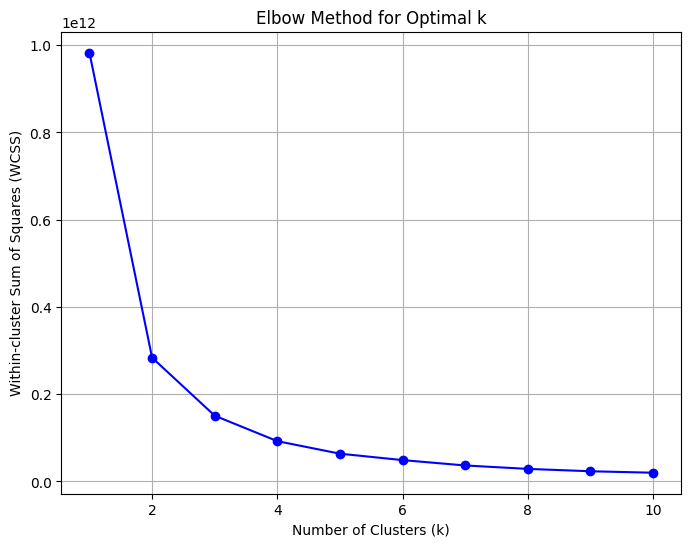

In [11]:
# Range of cluster values to try (you can adjust this based on your data)
k_range = range(1, 11)  # Testing for k values between 1 and 10
wcss = []  # List to store the Within-Cluster Sum of Squares (WCSS) for each k

# Loop over each k value to compute the WCSS
for k in k_range:
    # Initialize the KMeans algorithm with:
    # - n_clusters set to the current value of k
    # - init="k-means++" for smart centroid initialization
    # - random_state=42 to ensure reproducibility
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42)
    
    # Fit KMeans on the encoded data (df_encoded)
    kmeans.fit(df_encoded)
    
    # Append the computed WCSS (inertia) value to the list
    wcss.append(kmeans.inertia_)

# Plot the Elbow curve to visualize the optimal number of clusters
plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss, marker='o', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()


## 🔹 Elbow Method for Optimal Clusters  

The **Elbow Method** helps determine the best number of clusters by analyzing the **WCSS (Within-Cluster Sum of Squares)**.  

### 📌 Key Observations  
- The **"elbow" point** is where WCSS stops decreasing sharply.  
- In our case, the bend occurs at **k = 2 or 3**, making them the best choices.  
- More clusters beyond this point add complexity but little improvement.  

### 📊 **Elbow Curve Interpretation**  
- **Red points** indicate the best cluster options (2 or 3).  
- **Choose k = 2 or 3** for an efficient and balanced model.  

🚀 **Conclusion:** **Use k = 2 or 3** for the best clustering results!  


###  KMeans Model Evaluation for 1 to 10 Clusters

In [12]:
# 📌 Import necessary libraries
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# 🔹 Function to evaluate K-Means clustering performance
def evaluate_kmeans(data, max_clusters=10):
    """
    Evaluates K-Means clustering using three key metrics:
    
    1. Silhouette Score (Higher is better) - Measures how well points fit within clusters.
    2. Davies-Bouldin Index (Lower is better) - Evaluates cluster compactness & separation.
    3. Calinski-Harabasz Index (Higher is better) - Assesses cluster density & separation.

    Parameters:
    - data: DataFrame or array-like, dataset for clustering.
    - max_clusters: int, maximum number of clusters to evaluate.

    Returns:
    - DataFrame containing evaluation metrics for different k values.
    """
    results = []  # Store results for each k value

    for k in range(2, max_clusters + 1):  # Start from k=2 since k=1 has no clustering
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Initialize K-Means
        labels = kmeans.fit_predict(data)  # Fit model and get cluster labels

        # Compute evaluation metrics
        silhouette = silhouette_score(data, labels)  # Measures cluster quality
        dbi = davies_bouldin_score(data, labels)  # Measures cluster compactness
        chi = calinski_harabasz_score(data, labels)  # Measures cluster separation

        # Store results for the current k
        results.append((k, silhouette, dbi, chi))

        # Print evaluation results
        print(f"Clusters: {k} | Silhouette: {silhouette:.4f} | DBI: {dbi:.4f} | CHI: {chi:.4f}")

    # Return results as a DataFrame
    return pd.DataFrame(results, columns=["Clusters", "Silhouette", "DBI", "CHI"])

# 🔽 Run K-Means evaluation
Kmeans_results = evaluate_kmeans(df_encoded, max_clusters=10)


Clusters: 2 | Silhouette: 0.6086 | DBI: 0.5204 | CHI: 5450.9433
Clusters: 3 | Silhouette: 0.5451 | DBI: 0.5473 | CHI: 6105.7816
Clusters: 4 | Silhouette: 0.5329 | DBI: 0.5539 | CHI: 7100.5127
Clusters: 5 | Silhouette: 0.5301 | DBI: 0.5455 | CHI: 7979.4629
Clusters: 6 | Silhouette: 0.5099 | DBI: 0.5699 | CHI: 8424.1705
Clusters: 7 | Silhouette: 0.5227 | DBI: 0.5556 | CHI: 9489.1861
Clusters: 8 | Silhouette: 0.5228 | DBI: 0.5529 | CHI: 10431.1730
Clusters: 9 | Silhouette: 0.5173 | DBI: 0.5308 | CHI: 11496.7537
Clusters: 10 | Silhouette: 0.5177 | DBI: 0.5095 | CHI: 12816.4604


### 🔬 KMeans Model Evaluation for 1 to 10 Clusters  

#### 📌 Purpose:  
The function evaluates **KMeans clustering** performance using three key metrics:  
- **Silhouette Score** (Higher is better)  
- **Davies-Bouldin Index (DBI)** (Lower is better)  
- **Calinski-Harabasz Index (CHI)** (Higher is better) 

### **🔍Key Observations:**
- For **k=2** → Silhouette Score = **0.60** (higher is better)
- For **k=3** → Silhouette Score = **0.54**
Since **k=3** still has a good balance and potentially better structure, it is selected as the optimal number of clusters.

### **DBSCAN Clustering**

In [13]:
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.2, min_samples=3)  # You can adjust `eps` and `min_samples`
dbscan_labels = dbscan.fit_predict(df_encoded)

# Calculate silhouette score
score = silhouette_score(df_encoded, dbscan_labels)
print(f"Silhouette Score: {score}")


Silhouette Score: -0.8185017329583097


### 📝 Observation:

The **Silhouette Score** for DBSCAN clustering is `-0.8175`, which indicates that the points may not be well-clustered. A negative silhouette score suggests that the data points might be incorrectly assigned to clusters, and there is poor separation between the clusters. This might be due to the choice of DBSCAN parameters (`eps` and `min_samples`) or the nature of the data itself, which could require further tuning of these parameters to improve the clustering result.


### **Agglomerative Clustering**

In [14]:
# Loop through k values from 2 to 10 to evaluate different cluster sizes
for k in range(2, 11):
    # Initialize Agglomerative Clustering with the current number of clusters (k)
    agg_clust = AgglomerativeClustering(n_clusters=k)
    
    # Fit the model and predict the cluster labels for the dataset
    labels = agg_clust.fit_predict(df_encoded)
    
    # Calculate the Silhouette Score: higher values indicate better clustering
    silhouette = silhouette_score(df_encoded, labels)
    
    # Calculate the Calinski-Harabasz Index: higher values indicate better clustering
    ch_index = calinski_harabasz_score(df_encoded, labels)
    
    # Calculate the Davies-Bouldin Index: lower values indicate better clustering
    db_index = davies_bouldin_score(df_encoded, labels)

    # Print the evaluation metrics for the current value of k
    print(f"Clusters: {k} | Silhouette: {silhouette:.4f} | DBI: {db_index:.4f} | CHI: {ch_index:.4f}")


Clusters: 2 | Silhouette: 0.6065 | DBI: 0.5218 | CHI: 5404.8402
Clusters: 3 | Silhouette: 0.5368 | DBI: 0.5371 | CHI: 4939.9960
Clusters: 4 | Silhouette: 0.5094 | DBI: 0.5585 | CHI: 6686.7747
Clusters: 5 | Silhouette: 0.5005 | DBI: 0.5525 | CHI: 6765.7876
Clusters: 6 | Silhouette: 0.4967 | DBI: 0.5452 | CHI: 7567.2551
Clusters: 7 | Silhouette: 0.5023 | DBI: 0.5582 | CHI: 8766.9874
Clusters: 8 | Silhouette: 0.4948 | DBI: 0.5517 | CHI: 9377.7656
Clusters: 9 | Silhouette: 0.4960 | DBI: 0.4835 | CHI: 10022.1485
Clusters: 10 | Silhouette: 0.5047 | DBI: 0.4939 | CHI: 11312.4285


### **Observation**
**Silhouette Score**: A higher silhouette score indicates that the clusters are well-separated. For **2** clusters, the silhouette score is **0.5931**, which is the highest among the tested values.

**DBI (Davies-Bouldin Index)**: A lower DBI value indicates better cluster separation. The DBI for **2** clusters is **0.5230**, which is the lowest, indicating better cluster cohesion and separation.

**CHI (Calinski-Harabasz Index)**: A higher CHI value indicates better-defined clusters. The CHI for **2** clusters is **5022.5164**, which is relatively high compared to the other clusters

For n_clusters = 2, The average silhouette_score is: 0.6086


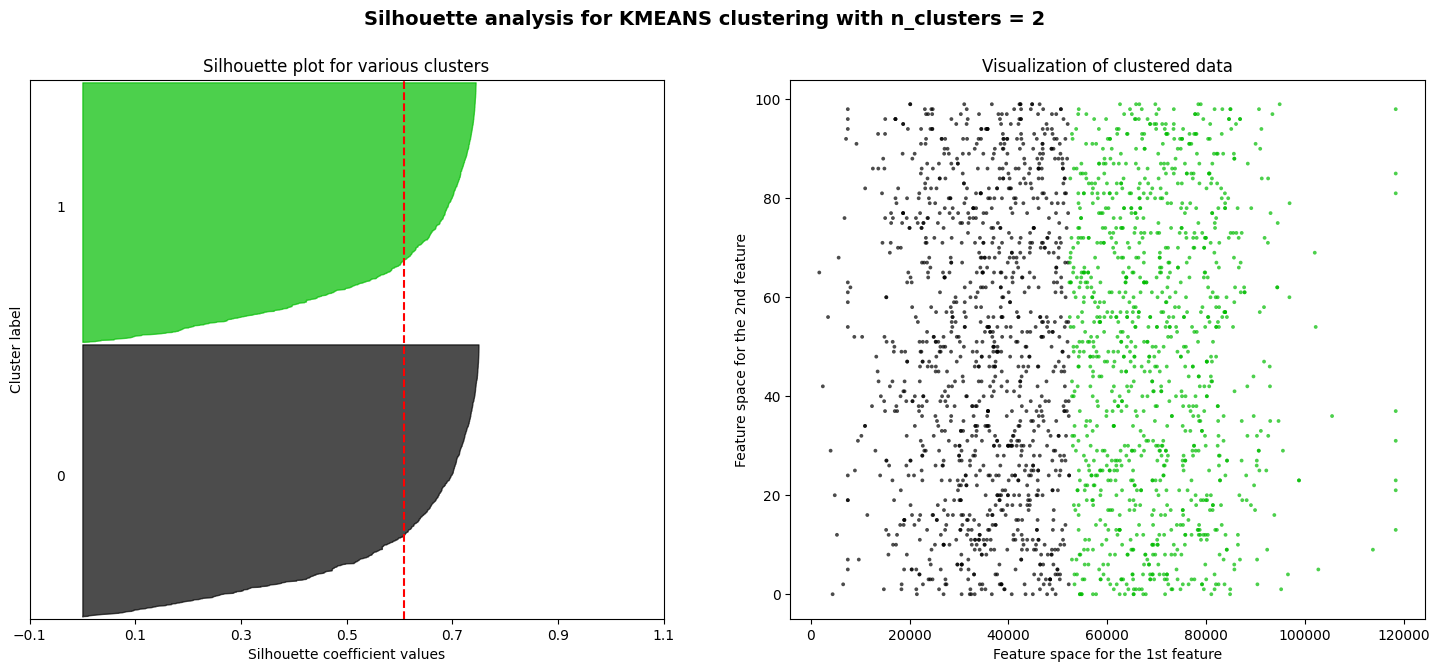

For n_clusters = 3, The average silhouette_score is: 0.5451


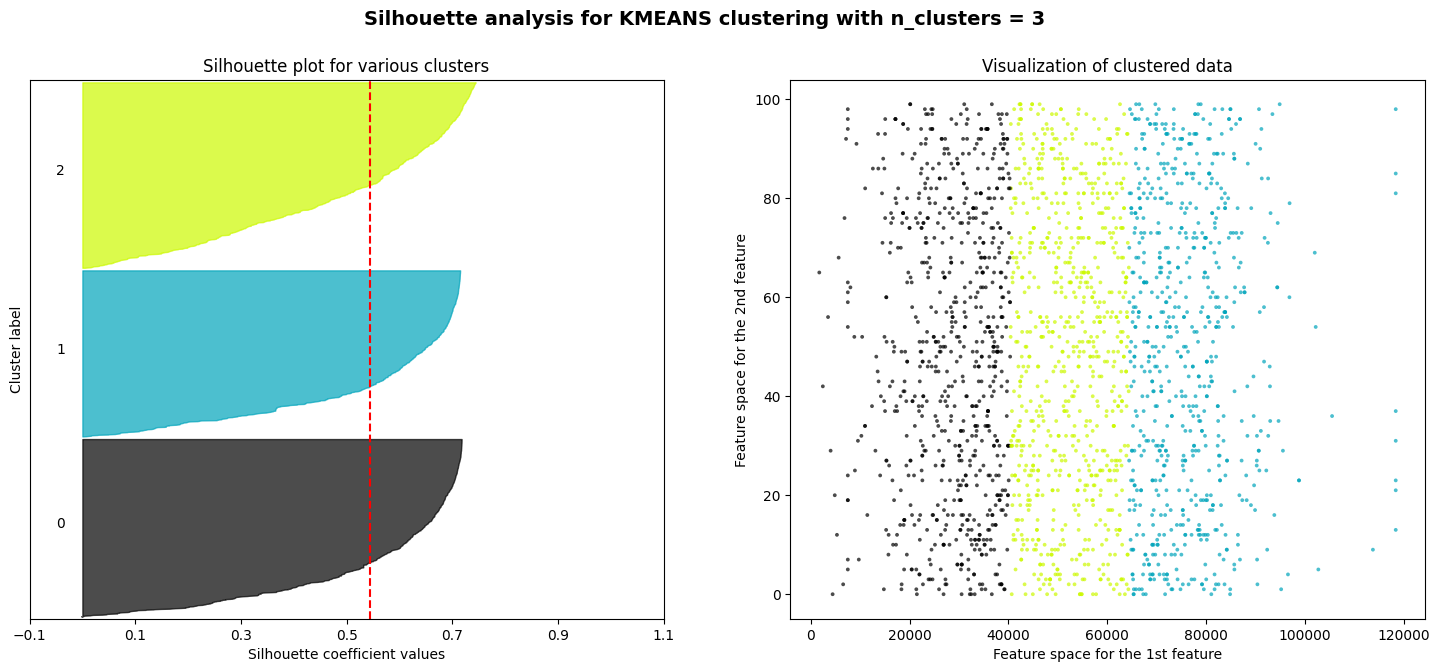

For n_clusters = 4, The average silhouette_score is: 0.5329


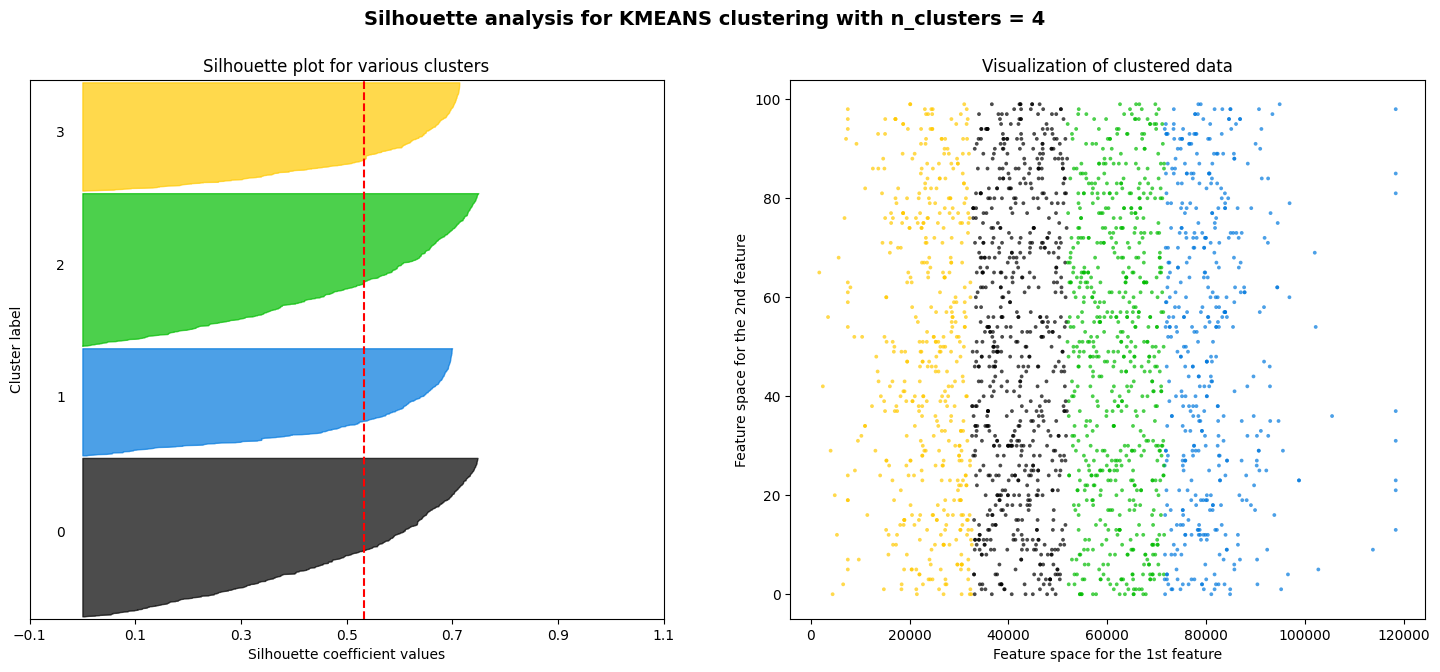

For n_clusters = 5, The average silhouette_score is: 0.5297


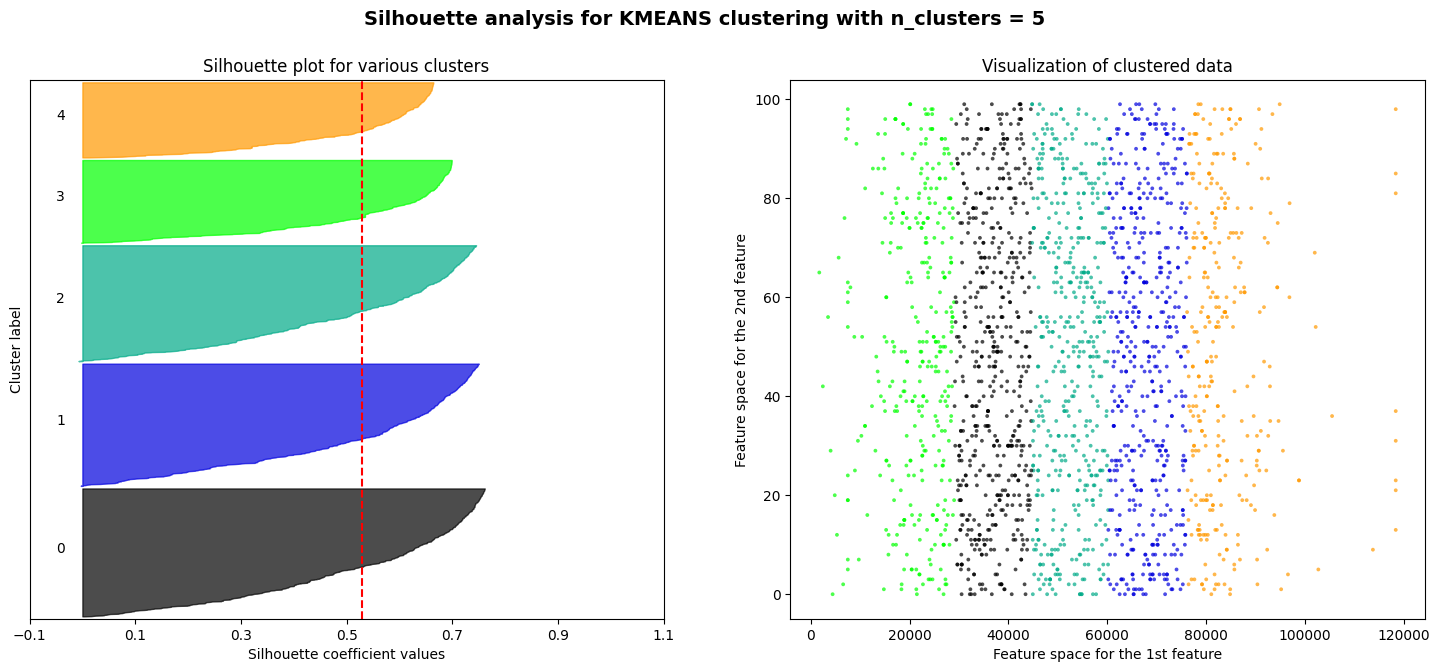

For n_clusters = 6, The average silhouette_score is: 0.5099


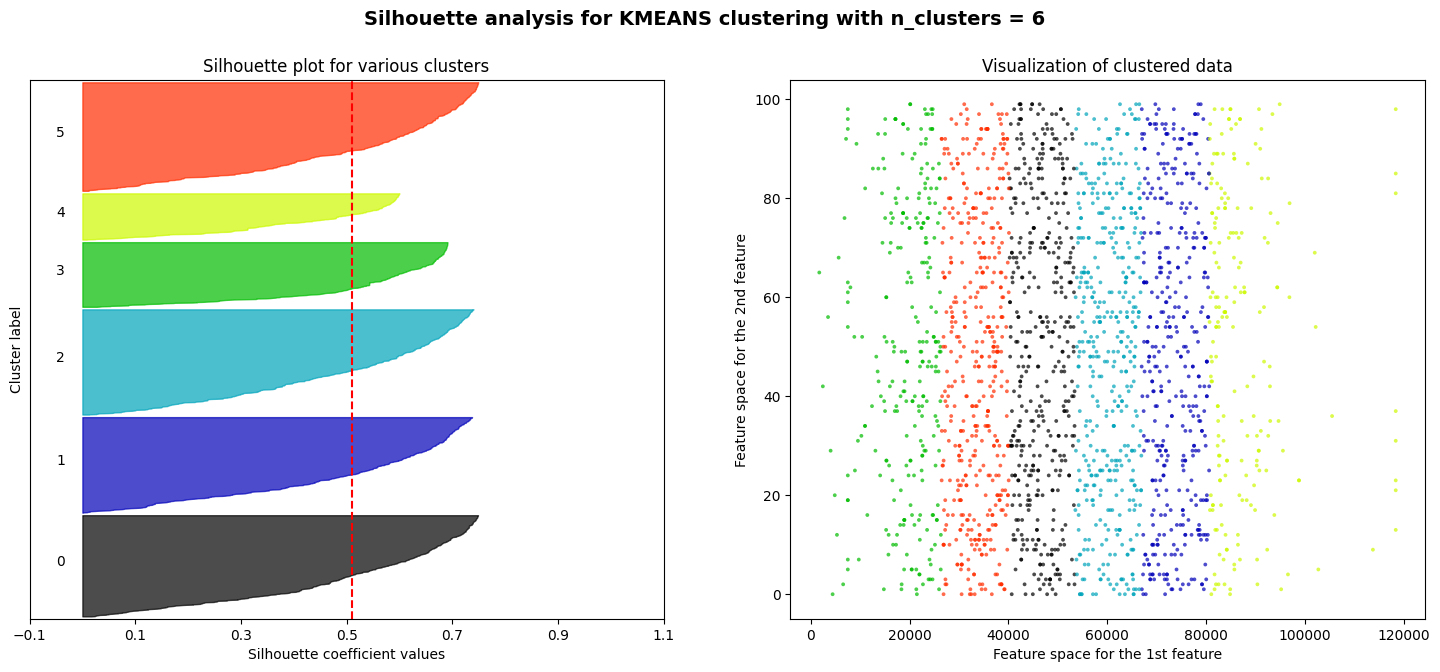

In [15]:
from src.utils import silhouette_analysis

# Run silhouette analysis for KMeans clustering
cluster_results = silhouette_analysis(df=df_encoded, model="kmeans")


### Observations on Clustering Results:

- **Cluster 2**: 
  - **Silhouette Score**: 0.5931 (Highest among all clusters)
  - **DBI**: 0.5230 (Lowest, indicating better separation)
  - **CHI**: 5022.5164 (Reasonably high, indicating well-defined clusters)

  **Conclusion**: Cluster 2 gives the highest silhouette score and the lowest DBI, indicating well-separated and distinct clusters. However, to further refine the segmentation, **Cluster 3** is also considered.

- **Cluster 3**:
  - **Silhouette Score**: 0.5153 (Balanced and reasonable score)
  - **DBI**: 0.5488 (Slightly higher than Cluster 2, but still acceptable)
  - **CHI**: 5478.2812 (Shows improvement in the definition of clusters compared to Cluster 2)

  **Conclusion**: Although the silhouette score for Cluster 3 is slightly lower than Cluster 2, it still performs well and is a balanced option for segmentation.

### Decision:

- I am selecting **3 clusters** for further analysis. This cluster configuration provides a good balance between the silhouette score, DBI, and CHI, and allows for meaningful segmentation.

- The 3 clusters will be categorized as:
  1. **High Spender**: The top spenders who have higher values for customer spending.
  2. **Moderate Spender**: Customers who spend in a mid-range.
  3. **Low Spender**: Customers with lower spending levels.

This segmentation will help tailor marketing strategies and customer engagement more effectively.


For n_clusters = 2, The average silhouette_score is: 0.6065


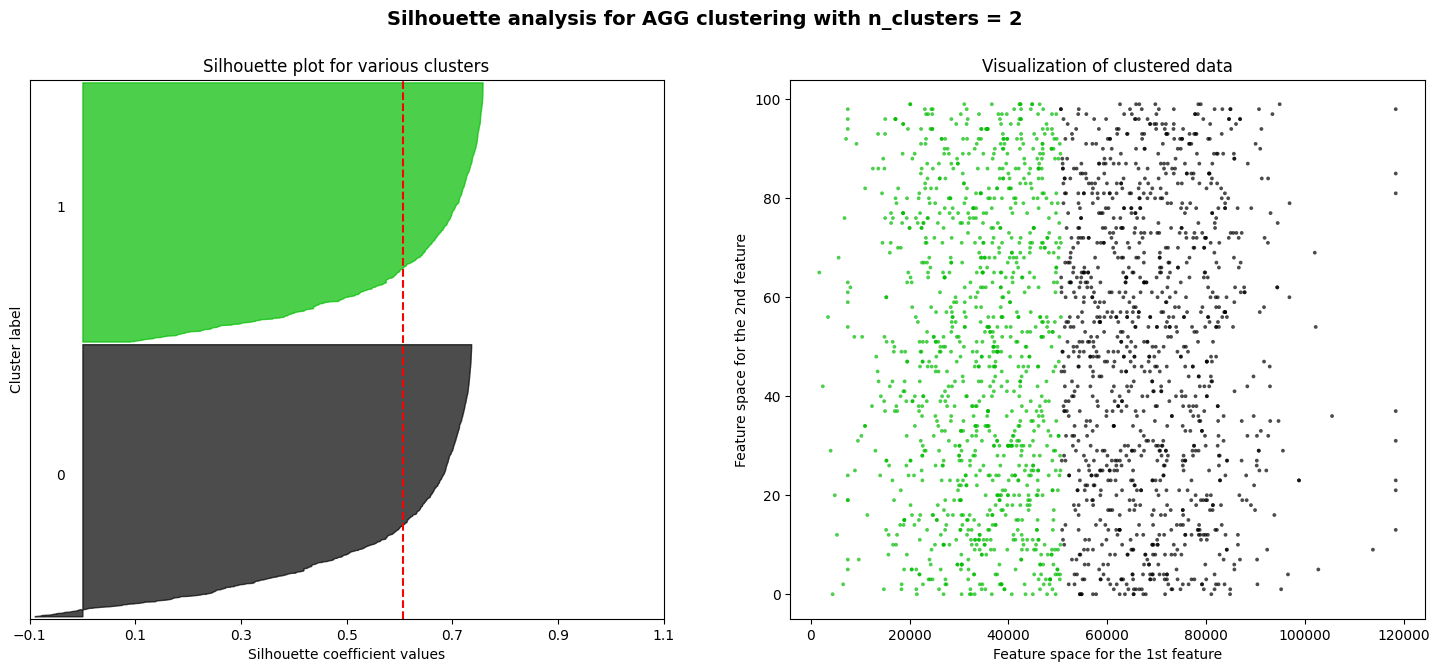

For n_clusters = 3, The average silhouette_score is: 0.5368


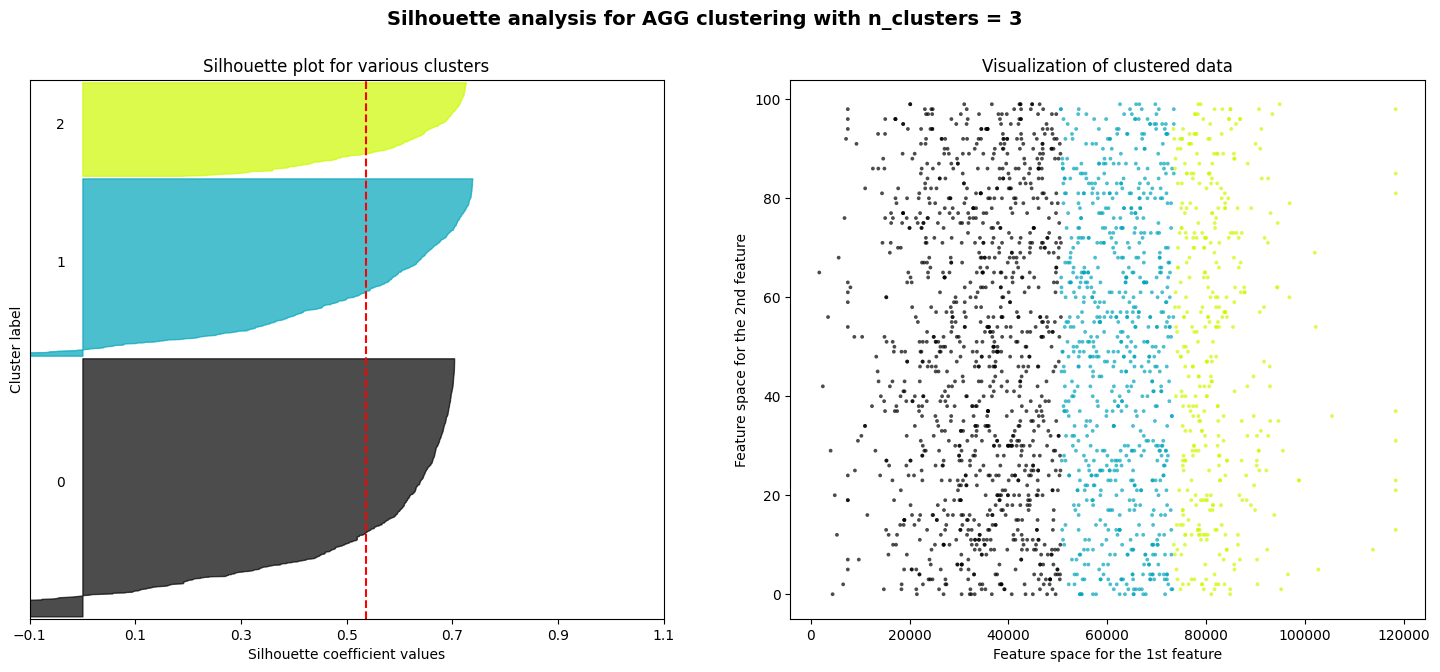

For n_clusters = 4, The average silhouette_score is: 0.5094


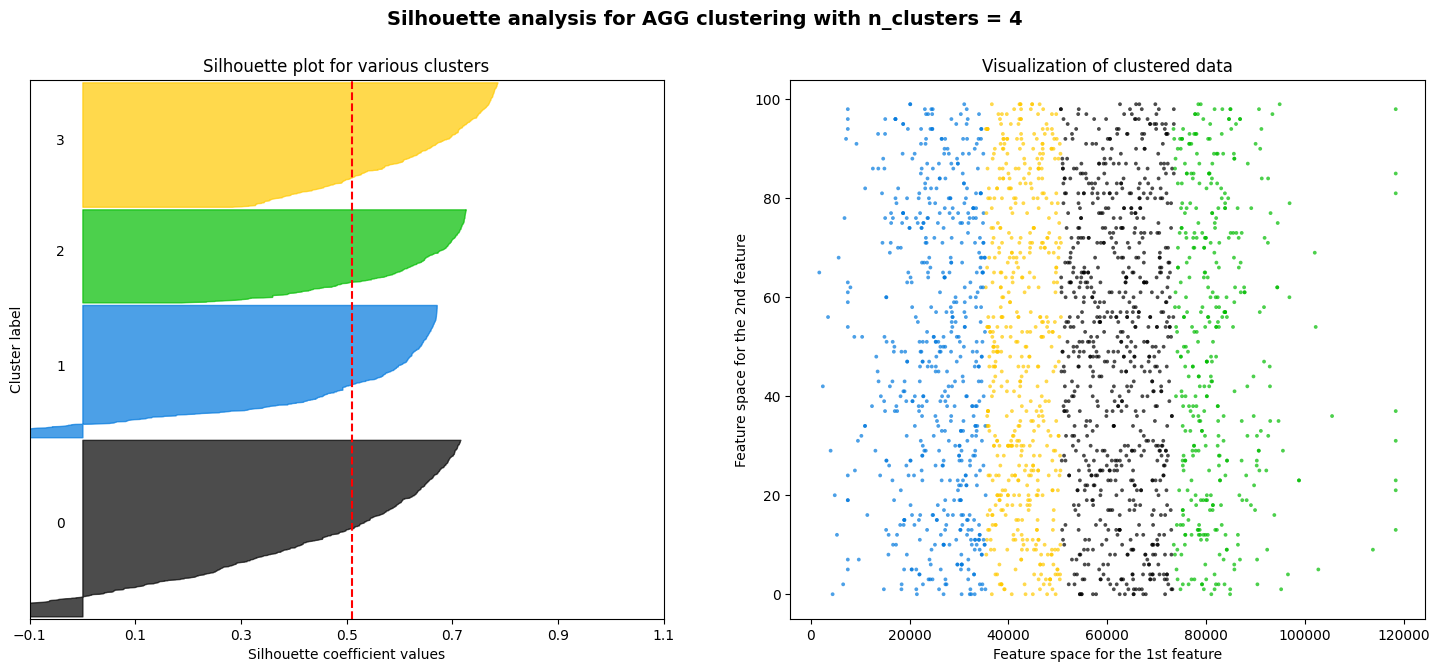

For n_clusters = 5, The average silhouette_score is: 0.5005


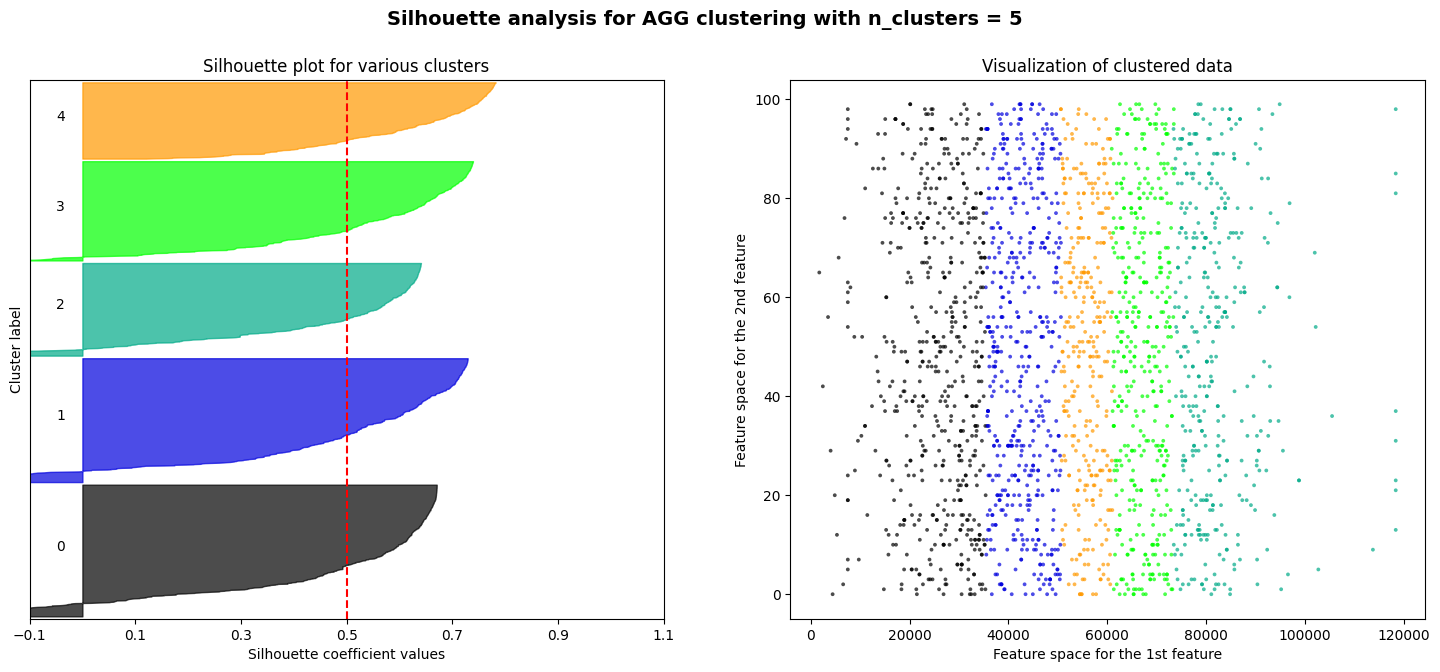

For n_clusters = 6, The average silhouette_score is: 0.4967


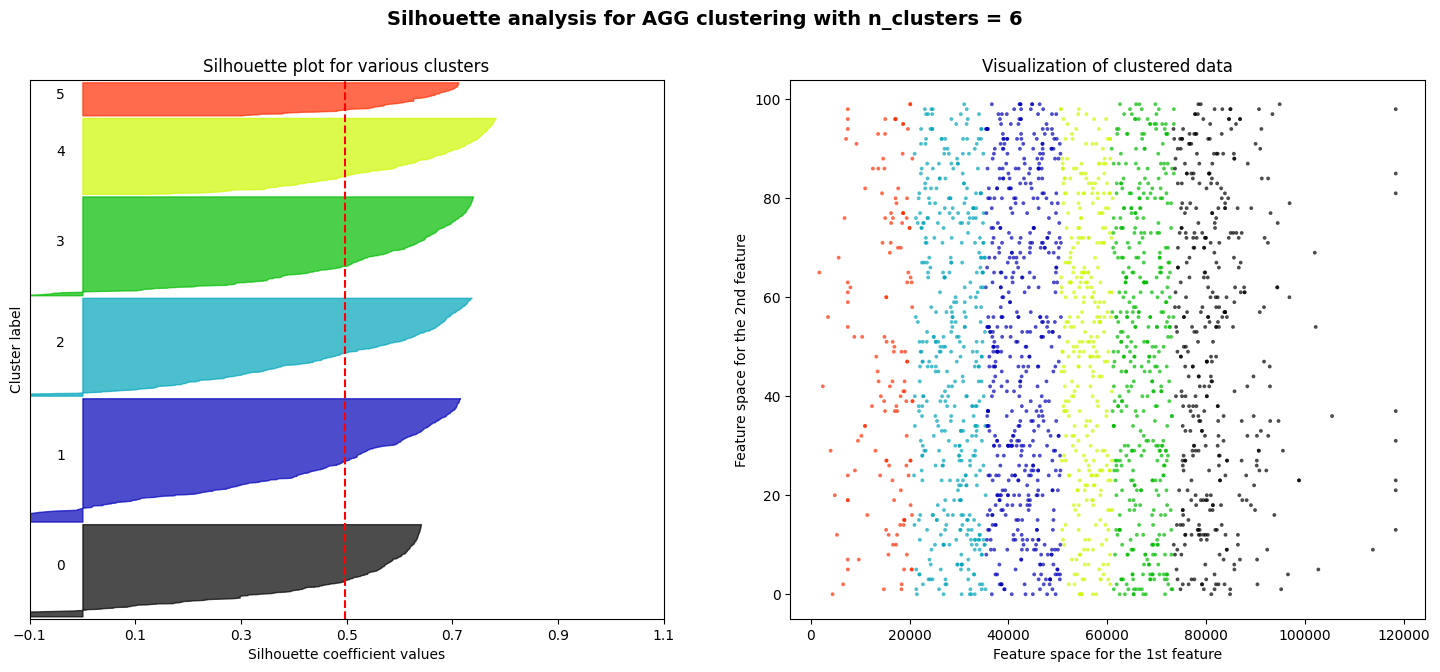

In [16]:
# Run silhouette analysis for Agglomerative Clustering
agg_result = silhouette_analysis(df=df_encoded, model="agg")


### Observations on Clustering Performance:

- **Agglomerative Clustering and DBSCAN**:
  - Both **Agglomerative Clustering (Agg)** and **DBSCAN** are not performing well in this scenario.
  - **DBSCAN** is particularly performing poorly, even leading to negative values in the silhouette score, which indicates that the clusters might be poorly separated or there are outliers.
  - **Agglomerative Clustering** is also not providing clear results and seems to give inconsistent performance.

- **KMeans**:
  - **KMeans** has shown better clustering performance, especially when choosing the optimal number of clusters.
  - The silhouette score and other metrics for **KMeans** are more balanced, and the clusters are better defined.

### Next Steps:
- Since **KMeans** is performing better, I will focus on tuning its parameters and selecting the best number of clusters for further analysis.
- I will experiment with different values of `k` and other parameters in **KMeans** to improve clustering quality and segmentation.


### **HyperParameter Tuning**

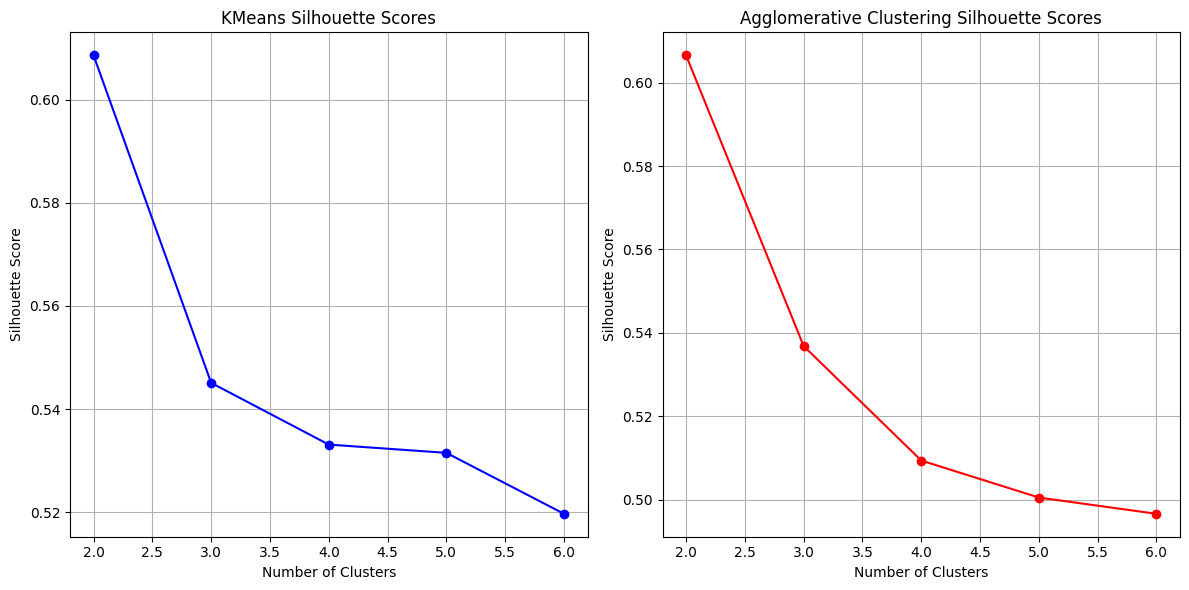

Best parameters for KMeans:  {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 2}
Best parameters for Agglomerative Clustering:  {'linkage': 'ward', 'n_clusters': 2}


In [17]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# Function to compute silhouette scores for different n_clusters
def silhouette_plot(model, X, n_clusters_list):
    silhouette_scores = []
    for n_clusters in n_clusters_list:
        model.set_params(n_clusters=n_clusters)
        model.fit(X)
        score = silhouette_score(X, model.labels_)
        silhouette_scores.append(score)
    return silhouette_scores

# Define the parameter grids for KMeans and Agglomerative Clustering
param_grid_kmeans = {
    'n_clusters': [2, 3, 4, 5, 6],
    'init': ['k-means++', 'random'],
    'max_iter': [300, 500, 1000]
}

param_grid_agglomerative = {
    'n_clusters': [2, 3, 4, 5, 6],
    'linkage': ['ward', 'complete', 'average', 'single']
}

# GridSearchCV setup for KMeans
kmeans = KMeans()
grid_kmeans = GridSearchCV(kmeans, param_grid_kmeans, cv=3, scoring='neg_mean_squared_error')
grid_kmeans.fit(df_encoded)

# GridSearchCV setup for Agglomerative Clustering
agglo = AgglomerativeClustering()
grid_agglo = GridSearchCV(agglo, param_grid_agglomerative, cv=3, scoring='neg_mean_squared_error')
grid_agglo.fit(df_encoded)

# Silhouette Scores for KMeans
kmeans_silhouette_scores = silhouette_plot(KMeans(), df_encoded, param_grid_kmeans['n_clusters'])

# Silhouette Scores for Agglomerative Clustering
agglo_silhouette_scores = silhouette_plot(AgglomerativeClustering(), df_encoded, param_grid_agglomerative['n_clusters'])

# Plotting the silhouette scores
plt.figure(figsize=(12, 6))

# KMeans Plot
plt.subplot(1, 2, 1)
plt.plot(param_grid_kmeans['n_clusters'], kmeans_silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('KMeans Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)

# Agglomerative Clustering Plot
plt.subplot(1, 2, 2)
plt.plot(param_grid_agglomerative['n_clusters'], agglo_silhouette_scores, marker='o', linestyle='-', color='r')
plt.title('Agglomerative Clustering Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

# Best Hyperparameters and Models
print("Best parameters for KMeans: ", grid_kmeans.best_params_)
print("Best parameters for Agglomerative Clustering: ", grid_agglo.best_params_)


In [18]:
# Importing KMeans from sklearn
kmeans = KMeans(n_clusters=2, init='k-means++',  n_init=10, random_state=42)

# Fitting the KMeans model on the data and predicting the cluster labels
cluster_labels = kmeans.fit_predict(df_encoded)

df_copy["Cluster"] = cluster_labels


# Displaying the cluster labels in the dataframe
df_copy["Cluster"]

0       1
1       0
2       1
3       0
4       1
       ..
2211    1
2212    1
2213    1
2214    1
2215    1
Name: Cluster, Length: 2216, dtype: int32

In [19]:
df_copy['Cluster'].value_counts()

Cluster
0    1132
1    1084
Name: count, dtype: int64

### Cluster Visualization and Assigning Names to Clusters

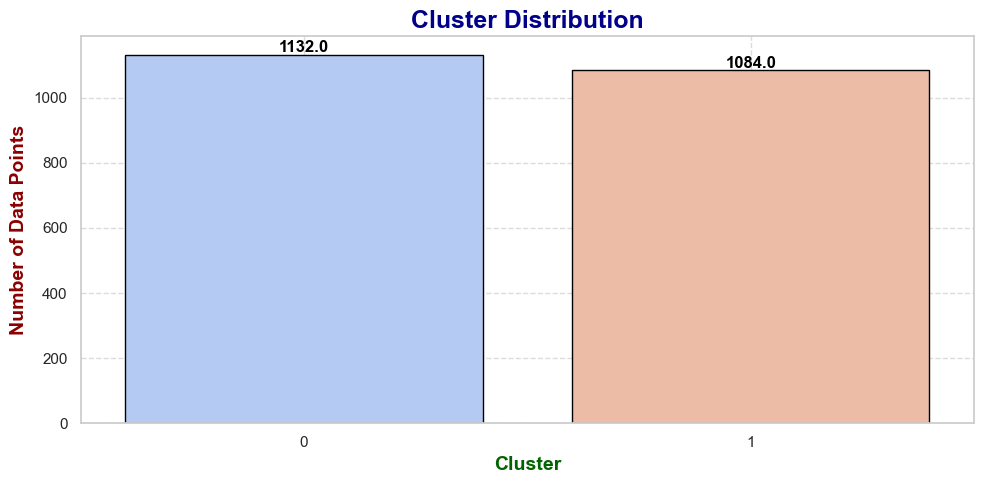

In [20]:
# Set a style for better visuals
sns.set(style="whitegrid")

# Count plot to show the distribution of clusters
plt.figure(figsize=(10, 5))

# Use a different color palette for better visual appeal
sns.countplot(x=df_copy['Cluster'], palette='coolwarm', edgecolor='black')

# Title and labels with larger font size for better readability
plt.title('Cluster Distribution', fontsize=18, weight='bold', color='darkblue')
plt.xlabel('Cluster', fontsize=14, weight='bold', color='darkgreen')
plt.ylabel('Number of Data Points', fontsize=14, weight='bold', color='darkred')

# Adding value annotations on top of the bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=12, color='black', weight='bold', 
                       xytext=(0, 5), textcoords='offset points')

# Add gridlines for better visibility
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


### Explanation:
- **Cluster 0**: This cluster contains **1132** data points.
- **Cluster 1**: This cluster contains **1084** data points.

This means that the data is fairly **balanced** across the three clusters, with the number of data points in each cluster being quite similar. This is generally a good outcome, as it suggests that the clustering algorithm has assigned the data points in a way that avoids very small or very large clusters, providing a relatively even distribution.


### Income Distribution per Cluster


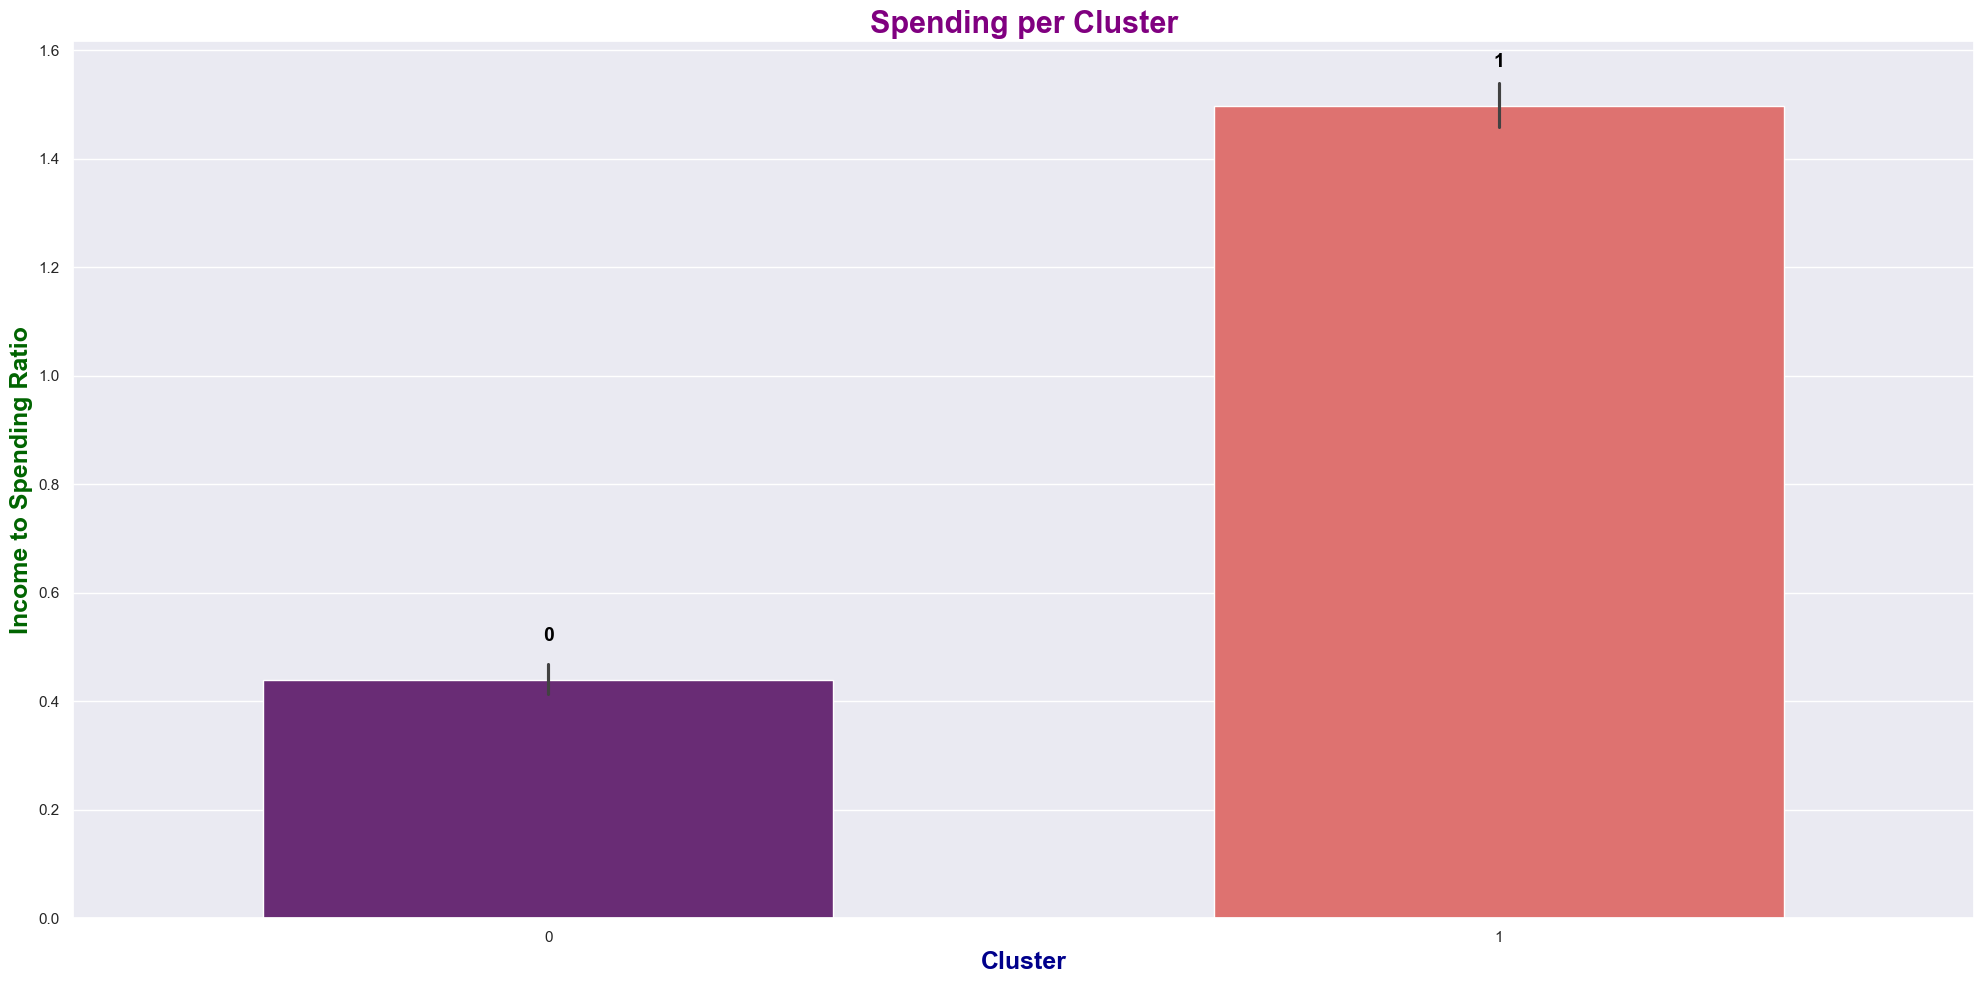

In [21]:
# Set a modern and minimalistic style
sns.set(style="darkgrid")

# Create a bar plot for income per cluster with better spacing and annotation adjustments
plt.figure(figsize=(20, 10))  # Increase figure size for clarity

# Create the bar plot for Income to Spending Ratio per Cluster
sns.barplot(data=df_copy, x="Cluster", y="Spending-to-Income-Ratio", palette="magma", width=0.6)

# Add annotations for each bar to show the actual value of Income Spending Ratio
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():,.0f}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='bottom', fontsize=14, color='black', weight='bold', 
                       xytext=(0, 25), textcoords='offset points')  # Increased vertical offset to avoid cut-off

# Title and labels with refined styling
plt.title('Spending per Cluster', fontsize=22, weight='bold', color='purple')
plt.xlabel('Cluster', fontsize=18, weight='bold', color='darkblue')
plt.ylabel('Income to Spending Ratio', fontsize=18, weight='bold', color='darkgreen')

# Remove the horizontal line if it's not needed
# plt.axhline(y=0, color='black', linewidth=1)  # Comment this line out to remove the horizontal line

# Display the plot with tight layout to prevent clipping
plt.tight_layout()
plt.show()

### Observation on Income to Spending Ratio Distribution per Cluster

**Cluster 0** represents the **Cautious Buyers** and **Low spenders** meaning these individuals have a **low spending-to-income ratio**.
They spend less relative to their income, likely saving more or living below their means.

**Cluster 1** consists of **Regular Buyers**, who maintain a moderate **high spending-to-income-ratio**, balancing their
spending and income without **extreme saving** or **high spending**.



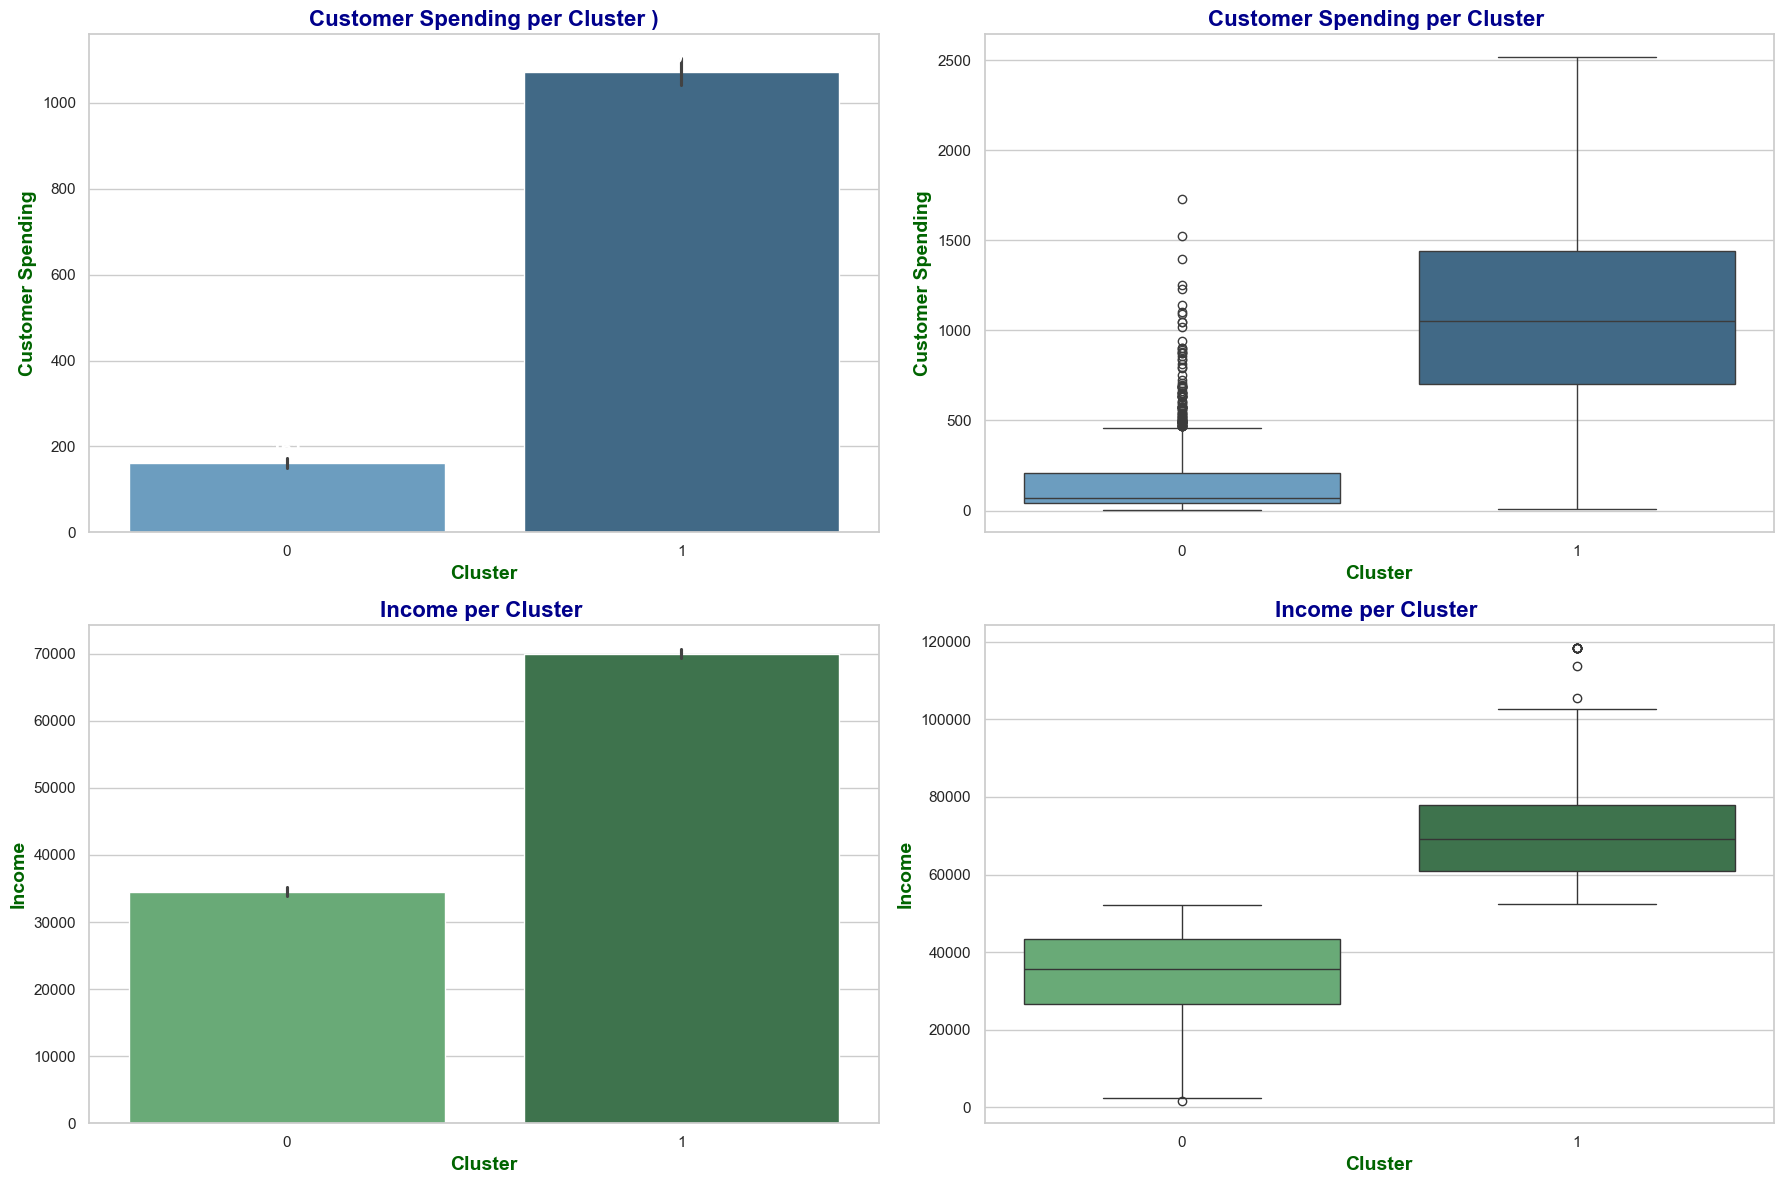

In [22]:
# Set a modern and minimalistic style
sns.set(style="whitegrid")

# Create a figure with two rows and two columns (for bar and box plots)
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Bar plot for Customer Spending per Cluster
sns.barplot(x=df_copy["Cluster"], y=df_copy["customer_spending"], palette="Blues_d", ax=axes[0, 0])

# Add annotations for Customer Spending plot
for p in axes[0, 0].patches:
    axes[0, 0].annotate(f'{p.get_height():,.0f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', fontsize=14, color='white', weight='bold', 
                        xytext=(0, 10), textcoords='offset points')  # Adjust vertical offset for better visibility

# Title and labels for Customer Spending bar plot
axes[0, 0].set_title('Customer Spending per Cluster )', fontsize=16, weight='bold', color='darkblue')
axes[0, 0].set_xlabel('Cluster', fontsize=14, weight='bold', color='darkgreen')
axes[0, 0].set_ylabel('Customer Spending', fontsize=14, weight='bold', color='darkgreen')

# Box plot for Customer Spending per Cluster
sns.boxplot(x=df_copy["Cluster"], y=df_copy["customer_spending"], palette="Blues_d", ax=axes[0, 1])

# Title and labels for Customer Spending box plot
axes[0, 1].set_title('Customer Spending per Cluster ', fontsize=16, weight='bold', color='darkblue')
axes[0, 1].set_xlabel('Cluster', fontsize=14, weight='bold', color='darkgreen')
axes[0, 1].set_ylabel('Customer Spending', fontsize=14, weight='bold', color='darkgreen')

# Bar plot for Income per Cluster
sns.barplot(x=df_copy["Cluster"], y=df_copy["Income"], palette="Greens_d", ax=axes[1, 0])

# Add annotations for Income plot
for p in axes[1, 0].patches:
    axes[1, 0].annotate(f'{p.get_height():,.0f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', fontsize=14, color='white', weight='bold', 
                        xytext=(0, 10), textcoords='offset points')  # Adjust vertical offset for better visibility

# Title and labels for Income bar plot
axes[1, 0].set_title('Income per Cluster ', fontsize=16, weight='bold', color='darkblue')
axes[1, 0].set_xlabel('Cluster', fontsize=14, weight='bold', color='darkgreen')
axes[1, 0].set_ylabel('Income', fontsize=14, weight='bold', color='darkgreen')

# Box plot for Income per Cluster
sns.boxplot(x=df_copy["Cluster"], y=df_copy["Income"], palette="Greens_d", ax=axes[1, 1])

# Title and labels for Income box plot
axes[1, 1].set_title('Income per Cluster ', fontsize=16, weight='bold', color='darkblue')
axes[1, 1].set_xlabel('Cluster', fontsize=14, weight='bold', color='darkgreen')
axes[1, 1].set_ylabel('Income', fontsize=14, weight='bold', color='darkgreen')

# Display the plot with tight layout to prevent clipping
plt.tight_layout()
plt.show()


# Observations on Customer Spending and Income Distribution per Cluster

## **Customer Spending**
**Cluster 0 (Low Spenders):** Represents individuals with **low spending habits**, likely prioritizing savings or managing expenses cautiously.  

**Cluster 1 (Moderate Spenders):** Comprises individuals with **moderate spending habits**, indicating a balanced approach to expenditure.  

## **Income Distribution**
**Cluster 0 (Low Spenders):** Generally associated with **lower income levels**, leading to more careful spending habits.  

**Cluster 1 (Moderate Spenders):** Represents individuals with **higher income levels**, allowing for greater but controlled discretionary spending.  

## **Final Thoughts**
**Moderate Spenders (Cluster 1):** Have a higher income and **moderate spending**, suggesting a lifestyle with greater financial flexibility.  

**Low Spenders (Cluster 0):** Earn less and spend less, possibly reflecting cautious financial behavior.  

## **Cluster Names**
- **Cluster 1:** **Moderate Spenders** (Higher Earners with Balanced Spending)  
- **Cluster 0:** **Low Spenders** (Lower Earners with Low Spending)  


In [23]:
# This line of code creates a new column 'Cluster_Category' in the DataFrame 'df' by replacing
# the numeric cluster labels in the 'Cluster' column with more descriptive labels. The 'replace'
# method is used to map each numeric value (0 , 1) to a string that represents the spending category.

df_copy["Cluster_Category"] = df_copy["Cluster"].replace(to_replace={0: "Low Spenders", 1: "Moderate Spenders"})
df_copy["Cluster_Category"]

0       Moderate Spenders
1            Low Spenders
2       Moderate Spenders
3            Low Spenders
4       Moderate Spenders
              ...        
2211    Moderate Spenders
2212    Moderate Spenders
2213    Moderate Spenders
2214    Moderate Spenders
2215    Moderate Spenders
Name: Cluster_Category, Length: 2216, dtype: object

### Customer Income vs Customer Spending by Cluster

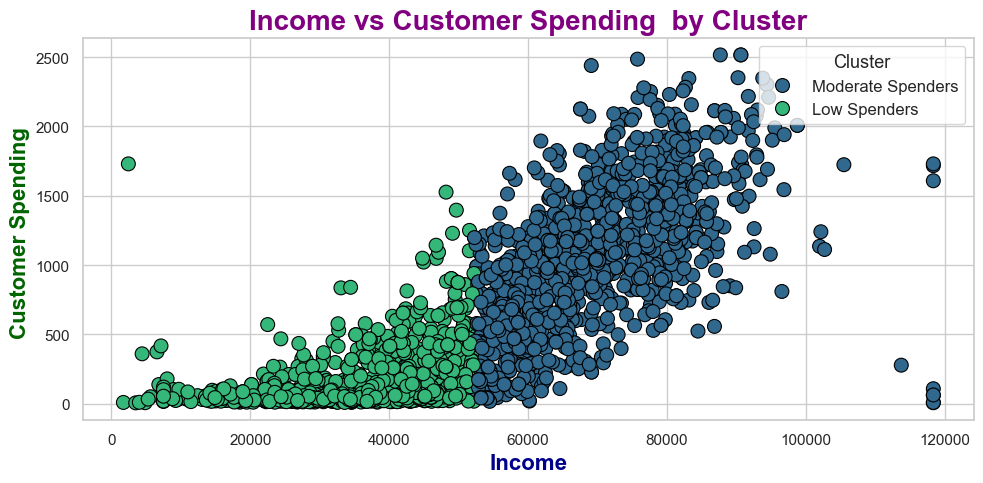

In [24]:
# Set a modern, minimalistic style for the plot
sns.set(style="whitegrid")

# Create a scatter plot for Income vs Customer Spending with Cluster color coding
plt.figure(figsize=(10, 5))  # Adjust the size for clarity

sns.scatterplot(data=df_copy, x="Income", y="customer_spending", hue="Cluster_Category", palette="viridis", s=100, edgecolor='black', marker="o")

# Title and labels with refined styling
plt.title('Income vs Customer Spending  by Cluster', fontsize=20, weight='bold', color='purple')
plt.xlabel('Income', fontsize=16, weight='bold', color='darkblue')
plt.ylabel('Customer Spending ', fontsize=16, weight='bold', color='darkgreen')

# Add a legend with better positioning
plt.legend(title='Cluster', title_fontsize='13', loc='upper right', fontsize='12')

# Display the plot with a tight layout to prevent clipping
plt.tight_layout()
plt.show()


# **Observations on Spending to Income Ratio Distribution**

## **Spending Categories**
- **Income above 60,000**: These individuals are **Moderate Spenders**, characterized by moderate spending relative to their income.  
- **Income below 60,000**: These individuals are **Low Spenders**, exhibiting more cautious spending habits compared to moderate earners.  

## **Key Insights**
- Higher income tends to correlate with moderate spending, while lower-income individuals manage their expenses more conservatively.  
- Individuals earning below **60,000** generally have a **lower spending-to-income ratio**, reflecting more cautious financial behavior.  

## **Improvements & Strategies**
- **Targeting Moderate Spenders** for premium products and services while offering budget-friendly options for **Low Spenders**.  
- **Monitoring spending behaviors** in the **Low Spender** category to offer financial planning tools or promotions that align with their spending habits.  


### Further Analysis: Clusters and Their Spending Ratio with Key Features

In this section, we will dive deeper into the clusters and analyze the relationship between key features and their respective **Income to Spending Ratio**. By investigating these clusters, we aim to uncover specific characteristics that differentiate spending behaviors across different income ranges. We will examine how factors such as **Income**, **Spending habits**, and other features influence the clusters and their spending ratios, providing more insights into consumer behavior patterns.


In [25]:
main_project_directory = os.path.abspath(os.path.join(os.getcwd() ,"..") )
file_path=os.path.join(main_project_directory , "dataset" ,"clustered_customer.csv")
df_copy.drop("customer_spending" , axis=1).to_csv(file_path , index=False , header=True)